In [1]:
import cv2
#import mtcnn
from random import choice
from matplotlib import pyplot
from PIL import Image
from numpy import asarray,expand_dims
import numpy as np
import tensorflow as tf
from os import listdir
from os.path import isdir
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow.keras.models import load_model 

In [2]:
cvNet = cv2.dnn.readNetFromCaffe('architecture.txt','weights.caffemodel')

facenet = load_model('facenet_keras.h5')
facenet.load_weights('facenet_keras_weights.h5')
facenet.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [3]:
def extract_face(filename, required_size=(160, 160)):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = asarray(image)
    (h, w) = pixels.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(pixels, (300,300)), 1.0, (300,300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    result = cvNet.forward()
    if result != []:
        box = result[0, 0, 0, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        image = pixels[startY:endY, startX:endX]
        image = Image.fromarray(image)
        image = image.resize(required_size)
        face_array = asarray(image)
        return face_array

In [4]:
def load_faces(directory):
    faces = list()
    for filename in listdir(directory):
        path = directory + filename
        face = extract_face(path)
        faces.append(face)
    return faces

In [5]:
def augment(face):
    i1 = tf.image.flip_left_right(face)
    aug_faces=[]
    aug_faces.append(face)
    aug_faces.append(i1)
    return asarray(aug_faces)

In [6]:
def load_dataset(directory):
    X, y = list(), list()
    for subdir in listdir(directory):
        path = directory + subdir + '/'
        if not isdir(path):
            continue
        faces = load_faces(path)
        labels = [subdir for _ in range(len(faces)*2)]
        aug_faces = augment(faces)
        print('loaded %d examples for class: %s' % (len(faces)*len(aug_faces), subdir))
        for i in aug_faces:
            X.extend(i)
        y.extend(labels)
    return asarray(X), asarray(y)

In [7]:
X,y = load_dataset('Dataset/')

C:\ProgramData\Anaconda3\envs\facereg\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


loaded 10 examples for class: Anshul
loaded 18 examples for class: Ashish
loaded 14 examples for class: Fahim
loaded 8 examples for class: Manith


In [8]:
X.shape

(50, 160, 160, 3)

In [9]:
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    samples = expand_dims(face_pixels, axis=0)
    yhat = model.predict(samples)
    return yhat[0]

In [10]:
trainX, testX, trainy, testy = train_test_split(X,y)

In [11]:
print(trainX.shape,trainy.shape,testX.shape,testy.shape)

(37, 160, 160, 3) (37,) (13, 160, 160, 3) (13,)


In [12]:
train_shape=(len(trainy),128)

embedtrain = list()
for face_pixels in trainX:
    embedding = get_embedding(facenet, face_pixels)
    embedtrain = np.append(embedtrain,embedding,axis=0)
    #embedtrain.append(embedding)
    embedtrain = asarray(embedtrain)
embedtrain = np.reshape(embedtrain,train_shape)
print(embedtrain.shape)

test_shape=(len(testy),128)

embedtest = list()
for face_pixels in testX:
    embedding = get_embedding(facenet, face_pixels)
    embedtest = np.append(embedtest,embedding,axis=0)
    #embedtest.append(embedding)
    embedtest = asarray(embedtest)
embedtest = np.reshape(embedtest,test_shape)
print(embedtest.shape)

(37, 128)
(13, 128)


In [13]:
norm = Normalizer(norm='l2')
embedtrain = norm.transform(embedtrain)
embedtest = norm.transform(embedtest)

encoder = LabelEncoder()
encoder.fit(trainy)
trainy = encoder.transform(trainy)
testy = encoder.transform(testy)

model = SVC(kernel='linear', probability=True)
model.fit(embedtrain, trainy)

yhat_train = model.predict(embedtrain)
yhat_test = model.predict(embedtest)

score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=100.000


In [14]:
from joblib import dump,load
dump(model,'SVC_model.joblib')
dump(encoder, 'OHE.joblib')
dump(norm, 'Normalizer.joblib')

['Normalizer.joblib']

Predicted: Ashish (85.252)
Expected: Ashish


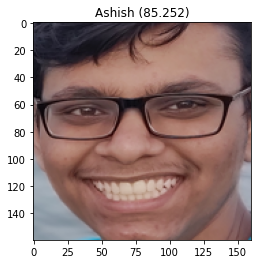

In [17]:
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX[selection]
random_face_emb = embedtest[selection]
random_face_class = testy[selection]
random_face_name = encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()